# Setting up a basic EasyVVUQ-Fabsim3 campaign

We will assume you have executed the basic EasyVVUQ assigment of day 2. Here, we will do the same, except we will **use FabSim3 to execute the ensembles, instead of the EasyVVUQ `ExecuteLocal` class**. As before, we will quantify the uncertainties of our simple advection-diffusion model:

\begin{align*}
\boxed{
\frac{du}{dx} - \frac{1}{Pe}\frac{d^2u}{dx^2} = f}
\end{align*}

This ODE solves for the velocity $u(x)$, where the spatial domain runs from $x\in[0,1]$. Homogeneous boundary conditions are applied: $u(0)=u(1)=0$. The solution $u$ depends upon two parameters:

* $Pe$: the so-called **Peclet number**, defined as the ratio between the rate of advection and the rate of diffusion,
* $f$: the constant forcing term.

A numerical solver (finite elements) of this equation is found in `advection_diffusion_model/advection_diffusion.py`.

In [1]:
#!which pip

In [2]:
#!pip install easyvvuq
#!pip install "numpy>=1.0,<2.0"

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import chaospy as cp
import easyvvuq as uq
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, ExecuteLocal, Actions

### Flags

These are the EasyVVUQ flags:

* `HOME`: simply the current directory,
* `WORK_DIR`: this is where all the EasyVVUQ ensembles runs will be stored,
* `CAMPAIGN_NAME`: this is the name of the EasyVVUQ campaign, explained later.

In [4]:
# home directory
HOME = os.getcwd()
# Work directory, where the easyVVUQ directory will be placed
WORK_DIR = '/tmp'
# EasyVVUQ Campaign name
CAMPAIGN_NAME = 'adv_diff'

### Define parameter space

We will have to define a dictionary that minimally describes the type (typically `float` or maybe `integer`) of each input, as well as its default value. Below we create the `params` dict for the Peclet number $Pe$ and forcing term $f$.

In [5]:
# Define parameter space: type & default value
params = {
    "Pe": {
        "type": "float",
        "default": 100.0},
    "f": {
        "type": "float",
        "default": 1.0}}

### Choose input distributions

Here we assign a probability density function to inputs from the `params` dict.  EasyVVUQ uses the Chaospy library for this purpose. A list of available distributions can be found [here](https://chaospy.readthedocs.io/en/master/reference/distribution/index.html).

All parameters that we actually want to vary are stored in the `vary`. These must also occur in the `params` dict. The converse is not true. If we only wish to vary a subset of the inputs in the `params` dict, we simply leave out the inputs in the `vary` dict that we do not want to change. These excluded inputs will automatically be assigned their default value in all ensemble runs.

**Assigment**: Assign uniform distribution to both inputs, using the `cp.Uniform` distribution, bounded to $\pm10\%$ of the defaults values:

In [6]:
vary = {'Pe' : cp.Uniform(0.9 * params['Pe']['default'], 1.1 * params['Pe']['default']),
        'f' :  cp.Uniform(0.9 * params['f']['default'], 1.1 * params['f']['default'])}
vary

{'Pe': Uniform(lower=90.0, upper=110.00000000000001),
 'f': Uniform(lower=0.9, upper=1.1)}

### Input file encoding

We require some way of feeding new parameter values to whatever simulation code we are examining. This is done by creating an **input template**. The `encoder` class cabn read this template and fill it with input samples drawn from the distributions of the `vary dict`. We will use the `GenericEncoder` for this purpose. It take 3 arguments:

* `template_fname`: this is the input template created in the previous exercise
* `delimiter`: the delimiter sought out by the encoder
* `target_filename`: the name of the input file

In [7]:
encoder = uq.encoders.GenericEncoder(template_fname='advection_diffusion_model/input.template',
                                     delimiter='$',
                                     target_filename='input.json')

### Output file decoding

We once more use the `SimpleCSV` decoder to extract the velocity $u$ from the CSV output file:

In [8]:
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', 
                                output_columns=['u'])

### Actions: creating a sequence of steps

Up to this point everything was the same an in the previous advection-diffusion tutorial. There we defined the following actions, stringing teh whole workflow into a single `Actions` object:

```python
execute = ExecuteLocal('python {}/advection_diffusion_model/advection_diffusion.py'.format(HOME))
actions = Actions(CreateRunDirectory(WORK_DIR, flatten=True), Encode(encoder), execute, Decode(decoder))
```

Here, we will break the Actions in three pieces:

1) Create the ensemble directories and encode the input file

2) Run ensemble using FabSim3

3) Decode

Step 1:

In [9]:
# create the run directories and encode the input file
actions = Actions(CreateRunDirectory(WORK_DIR, flatten=True),
                  Encode(encoder))

Create a campain:

In [10]:
campaign = uq.Campaign(work_dir=WORK_DIR, name=CAMPAIGN_NAME,
                       params=params, actions=actions)

Select a sampler:

In [11]:
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=3)
campaign.set_sampler(sampler)

And execute the actions. At this point you can check if `WORKDIR` contains your campaign directory with encoded input files. The code itself has not been executed yet.

In [12]:
campaign.execute().collate()

## Linking EasyVVUQ and FabSim3

We will assume you have FabSim3 installed, as well as the `FabUQCampaign` plugin. If not, you can find instructions [here](https://github.com/ScientificComputingCWI/SemesterProgramme-UQ/blob/main/INSTALL.md).

You will now need to configure the FabSim3 script, config and `machines_user.yml` file.

**machines_user.yml**

This file is located in `FabSim3/fabsim/deploy`. Open it. This is an important file that lets you configure your run environment for various machines, both your `localhost` as well as remote machines. We need to tell FabSim where we can find the advection-diffusion solver (the one in this repo ``advection_diffusion_model/advection_diffusion.py``). Under the `localhost` machine add the last line that says `ade_exec_school`

```python
localhost:
  username: wouter
  partition_name: "standard"
  qos_name: "short"
  runtime: 10
  nodes: 1
  ranks: 1
  cores_per_rank: 1
  home_path_template: "/home/wouter/FabSim3/localhost_exe"
  ade_exec_school: "<your full path to advection_diffusion.py>"
```

**Script**

This is simply the file that contains the command-line instruction to run the advection diffusion equation Python script, similar to the argument passed to `ExecuteLocal` that we used before. Do the following:

* Go to `FabSim3/plugins/FabUQCampaign/templates`. Create a new script `ade_school`. Our model is a simple python script, so the following instructions will suffice:

```
cd $job_results
$run_prefix

python3 $ade_exec_school
```

This will just enter the correct run directory, and execute the `$ade_exec_school` script that we defined in `machines_user.yml`. Note that the scripts are just command line instrucions, so other (non-Python) models can be executed as well in the same manner.

**Config**

The model config files (if any) are located in `FabSim3/plugins/FabUQCampaign/config`. We will call our config `ade_school` again, make an empty directory with that name in `FabSim3/plugins/FabUQCampaign/templates`. That's all we need to do, al least in this case. If your model requires additional config files, perhaps stored in some predefined directory structure, this is where you would place that. Those will then be automatically copied to every ensemble member.

We will set the following FabSim3 flags, in line with what was discussen above:

In [13]:
# FabSim3 config name
CONFIG = 'ade_school'
# FabSim3 script name
SCRIPT = 'ade_school'
# machine to run ensemble on
MACHINE = "localhost"

### FabSim3-Python interface

FabSim3 is a commandline tool, but FabUQCampaign also has a Python interface that is simply a shell over the commandline tools. To import it use

In [14]:
# Import the FabSim3 commandline interface
import fabsim3_cmd_api as fab

We are now ready to submit the ensemble, in this case to `localhost`. The command `fab.run_uq_ensemble` submits the ensemble to the (remote) host for execution. Under the hood it uses the FabSim3 `campaign2ensemble` subroutine to copy the run directories from `WORK_DIR` to the FabSim3 `SWEEP` directory, located in `config_files/ade_school/SWEEP`. From there the ensemble will be sent to the (remote) host.

In [15]:
fab.run_uq_ensemble(CONFIG, campaign.campaign_dir, script=SCRIPT, machine=MACHINE, PJ=False)

Executing fabsim localhost run_uq_ensemble:ade_school,campaign_dir=/tmp/adv_diffxxpyi8zq,script=ade_school,skip=0,PJ=False


This will check every minute on the status of the jobs on the remote host, and sleep otherwise, halting further execution of the script. On the localhost this command doesn't do anything.

In [16]:
# wait for job to complete
fab.wait(machine=MACHINE)

True

`fab.verify` will execute the `verify_last_ensemble` subroutine to see if the output file `target_filename` (`output.csv` in our case) for each run in the `SWEEP` directory is present in the corresponding FabSim3 results directory. Returns a boolean flag. `fab.verify` will also call the FabSim `fetch_results` method, which actually retrieves the results from the (remote) host. 

So, if you want to just get the results without verifying the presence of output files, call `fab.fetch_results(machine=MACHINE)` instead. However, if something went wrong on the (remote) host, this will cause an error later on since not all required output files will be transfered on the EasyVVUQ `WORK_DIR`.

In [17]:
# check if all output files are retrieved from the remote machine, returns a Boolean flag
all_good = fab.verify(CONFIG, campaign.campaign_dir,
                      'output.csv',
                      machine=MACHINE)

Executing fabsim localhost fetch_results
Executing fabsim localhost verify_last_ensemble:ade_school,campaign_dir=/tmp/adv_diffxxpyi8zq,target_filename=output.csv,machine=localhost


`fab.get_uq_samples` copies the samples from the (local) FabSim results directory to the (local) EasyVVUQ campaign directory. It will not delete the results from the FabSim results directory. If you want to save space, you can delete the results on the FabSim side (see `results` directory in your FabSim home directory). You can also call `fab.clear_results(machine, name_results_dir)` to remove a specific FabSim results directory on a given machine.

In [18]:
if all_good:
    # copy the results from the FabSim results dir to the EasyVVUQ results dir
    fab.get_uq_samples(CONFIG, campaign.campaign_dir, sampler.n_samples, machine=MACHINE)
else:
    print("Not all samples executed correctly")
    import sys
    sys.exit()

Executing fabsim localhost get_uq_samples:ade_school,campaign_dir=/tmp/adv_diffxxpyi8zq,number_of_samples=16,skip=0


#### Error handling

If `all_good == False` something went wrong on the (remote) host, and `sys.exit()` is called in our example, giving you the opportunity of investigating what went wrong. It can happen that a (small) number of jobs did not get executed on the remote host for some reason, whereas (most) jobs did execute succesfully. In this case simply resubmitting the failed jobs could be an option:

```python
fab.remove_succesful_runs(CONFIG, campaign.campaign_dir)
fab.resubmit_previous_ensemble(CONFIG, 'ade')
```

The first command removes all succesful run directories from the `SWEEP` dir for which the output file `TARGET_FILENAME` has been found. For this to work, `fab.verify` must have been called. Then, `fab.resubmit_previous_ensemble` simply resubmits the runs that are present in the `SWEEP` directory, which by now only contains the failed runs. After the jobs have finished, call `fab.verify` again to see if now `TARGET_FILENAME` is present in the results directory, for every run in the `SWEEP` dir.

### Continue the EasyVVUQ workflow

At this point, the ensemble has been executed, and the results are copied back to the EasyVVUQ `WORK_DIR`. Thus we can continue as before, once we decode the output files:

In [19]:
# All output files are present, decode them #

actions = uq.actions.Actions(
    uq.actions.Decode(decoder),
)
campaign.replace_actions(CAMPAIGN_NAME, actions)

###########################
# Execute decoding action #
###########################

campaign.execute().collate()

### Retrieving the raw results

This is the raw EasyVVUQ data.

In [20]:
df = campaign.get_collation_result()
df

run_id iteration          Pe         f             u                      \
      0         0           0         0             0         1         2     
0       1         0   91.388637  0.913886 -9.270314e-15  0.002285  0.004569   
1       2         0   91.388637  0.966002  2.150917e-14  0.002415  0.004830   
2       3         0   91.388637  1.033998  1.726124e-14  0.002585  0.005170   
3       4         0   91.388637  1.086114  3.224782e-14  0.002715  0.005431   
4       5         0   96.600190  0.913886 -1.683285e-14  0.002285  0.004569   
5       6         0   96.600190  0.966002  8.775032e-15  0.002415  0.004830   
6       7         0   96.600190  1.033998  8.449676e-16  0.002585  0.005170   
7       8         0   96.600190  1.086114  3.000161e-14  0.002715  0.005431   
8       9         0  103.399810  0.913886 -1.021608e-14  0.002285  0.004569   
9      10         0  103.399810  0.966002  8.060433e-15  0.002415  0.004830   
10     11         0  103.399810  1.033998  4.545112e-15  0.002585  0.005170   
11     12         0  103.399810  1.086114  2.957729e-14  0.002715  0.005431   
12     13         0  108.611363  0.913886 -2.943002e-14  0.002285  0.004569   
13     14         0  108.611363  0.966002  1.450267e-15  0.002415  0.004830   
14     15         0  108.611363  1.033998 -7.947273e-15  0.002585  0.005170   
15     16         0  108.611363  1.086114  2.086219e-14  0.002715  0.005431   

                                  ...                                          \
         3         4         5    ...       391       392       393       394   
0   0.006854  0.009139  0.011424  ...  0.777456  0.749855  0.714544  0.669536   
1   0.007245  0.009660  0.012075  ...  0.821792  0.792616  0.755292  0.707717   
2   0.007755  0.010340  0.012925  ...  0.879637  0.848408  0.808456  0.757533   
3   0.008146  0.010861  0.013576  ...  0.923973  0.891169  0.849204  0.795714   
4   0.006854  0.009139  0.011424  ...  0.790446  0.764473  0.730740  0.687113   
5   0.007245  0.009660  0.012075  ...  0.835522  0.808068  0.772411  0.726296   
6   0.007755  0.010340  0.012925  ...  0.894334  0.864948  0.826780  0.777420   
7   0.008146  0.010861  0.013576  ...  0.939410  0.908543  0.868452  0.816603   
8   0.006854  0.009139  0.011424  ...  0.805255  0.781394  0.749772  0.708084   
9   0.007245  0.009660  0.012075  ...  0.851175  0.825954  0.792529  0.748463   
10  0.007755  0.010340  0.012925  ...  0.911089  0.884093  0.848314  0.801147   
11  0.008146  0.010861  0.013576  ...  0.957010  0.928653  0.891071  0.841527   
12  0.006854  0.009139  0.011424  ...  0.815163  0.792891  0.762904  0.722777   
13  0.007245  0.009660  0.012075  ...  0.861649  0.838107  0.806409  0.763994   
14  0.007755  0.010340  0.012925  ...  0.922300  0.897100  0.863172  0.817771   
15  0.008146  0.010861  0.013576  ...  0.968785  0.942316  0.906677  0.858988   

                                                           
         395       396       397       398       399  400  
0   0.612330  0.539778  0.447924  0.331787  0.185106  0.0  
1   0.647249  0.570560  0.473467  0.350708  0.195662  0.0  
2   0.692808  0.610721  0.506794  0.375394  0.209434  0.0  
3   0.727727  0.641503  0.532338  0.394315  0.219990  0.0  
4   0.630876  0.558564  0.465764  0.346847  0.194641  0.0  
5   0.666852  0.590417  0.492325  0.366627  0.205740  0.0  
6   0.713791  0.631976  0.526979  0.392433  0.220222  0.0  
7   0.749768  0.663829  0.553540  0.412213  0.231322  0.0  
8   0.653342  0.581670  0.488043  0.365942  0.206915  0.0  
9   0.690600  0.614841  0.515874  0.386811  0.218715  0.0  
10  0.739210  0.658119  0.552186  0.414038  0.234110  0.0  
11  0.776468  0.691289  0.580017  0.434906  0.245910  0.0  
12  0.669325  0.598362  0.504385  0.380165  0.216199  0.0  
13  0.707494  0.632484  0.533148  0.401844  0.228528  0.0  
14  0.757294  0.677004  0.570676  0.430130  0.244614  0.0  
15  0.795463  0.711127  0.599440  0.451809  0.256943  0.0  

[16 rows x 405 columns]

### Analysis: postprocessing the results

In [21]:
results = campaign.analyse(qoi_cols=['u'])
results.supported_stats()

/home/wouter/py-env/lib/python3.9/site-packages/easyvvuq/analysis/sc_analysis.py:1279: RuntimeWarning: invalid value encountered in divide
  sobol[u] = D_u[u] / D


['mean', 'var', 'std']

### Plotting moments

Here we once again plot the mean and standard deviation.

In [22]:
code_samples = results.samples['u'].values
xx = np.linspace(0, 1, code_samples.shape[1])

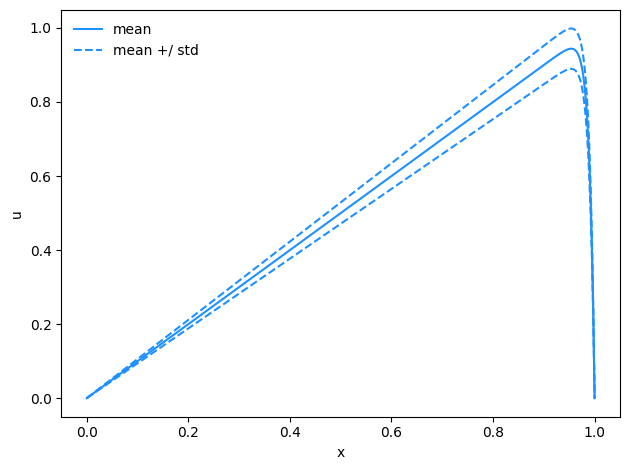

In [23]:
mean = results.describe(qoi = 'u', statistic = 'mean')
std = results.describe(qoi = 'u', statistic = 'std')

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel = 'u')
ax.plot(xx, mean, color='dodgerblue', label='mean')
ax.plot(xx, mean + std, '--', color='dodgerblue', label='mean +/ std')
ax.plot(xx, mean - std, '--', color='dodgerblue')
plt.legend(frameon = False)
plt.tight_layout()
plt.tight_layout()

### Fast sampling using the surrogate

We again run the SC or PCE surrogate

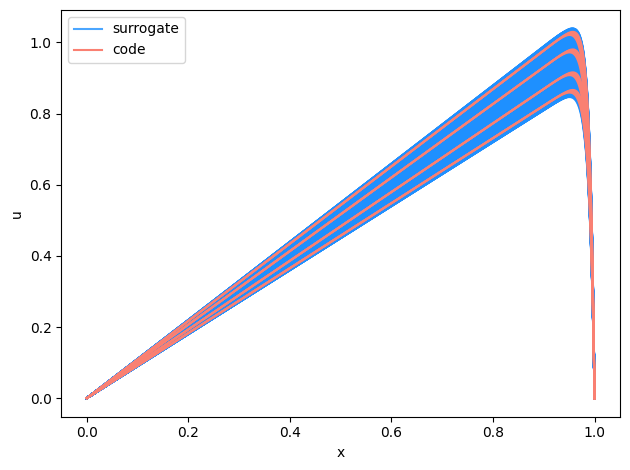

In [24]:
surrogate = results.surrogate()

random_inputs = {}
n_samples = 1000
for param in vary.keys():
    random_inputs[param] = vary[param].sample(n_samples)

u_surrogate = surrogate(random_inputs)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel = 'u')
ax.plot(xx, np.array(u_surrogate['u']).T, color='dodgerblue', alpha=0.8, label='surrogate')
ax.plot(xx, code_samples.T, color='salmon', label='code')

# legend, but remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()

### Plotting the Sobol indices

And we plot the Sobol indices.

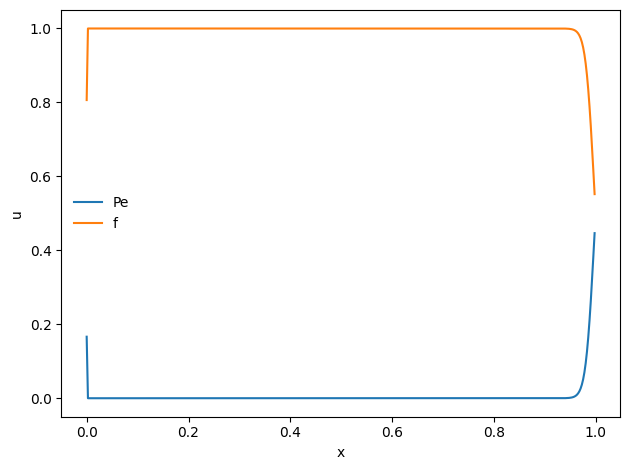

In [25]:
sobols_first = results.sobols_first()

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel = 'u')

for param in vary:
    ax.plot(xx, sobols_first['u'][param], label=param)

plt.legend(frameon = False)
plt.tight_layout()

## Assigment: repeat on Archer2

If you have aquired access to Archer2, you can redo this exercise, except run the ensemble on Archer2 instead on your laptop. To do you you will need to:

* copy the advection-diffusion model to a location in Archer2
* specify this location in the `archer2:` section of your `machines_user.yml` file. **TO DO**: specify what to do with `run_prefix_commands`, `budget` etc.
* switch the `MACHINE` flag from `localhost` to `archer2`